# Etude de cas de la Corée du Sud

Nous allons élaborer des modeles de prédiction linéaires et non-linéaires pour la Corée du Sud afin de proposer des prédictions dont on comparera les performances de maniere quantitatives. Nous allons proposer, pour le meilleur modele obtenu, des prévisions à l’échelle des mois à venir.

In [1]:
!pip install statsmodels

In [2]:
!pip install sklearn

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import mean_squared_error
from math import sqrt

On importe les fichier csv contenant les données de PIB de la Corée du Sud de 1960 à aujourd'hui.

(Source : https://data.oecd.org/fr/gdp/pib-trimestriel.htm)

In [4]:
df = pd.read_csv('pib_coree.csv')
df

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,KOR,QGDP,TOT,PC_CHGPP,Q,1960-Q2,4.496005,NaN
1,KOR,QGDP,TOT,PC_CHGPP,Q,1960-Q3,-1.111563,NaN
2,KOR,QGDP,TOT,PC_CHGPP,Q,1960-Q4,0.596299,NaN
3,KOR,QGDP,TOT,PC_CHGPP,Q,1961-Q1,3.200927,NaN
4,KOR,QGDP,TOT,PC_CHGPP,Q,1961-Q2,4.316423,NaN
...,...,...,...,...,...,...,...,...
471,OECD,QGDP,TOT,PC_CHGPP,Q,2019-Q3,0.427321,NaN
472,OECD,QGDP,TOT,PC_CHGPP,Q,2019-Q4,0.190146,NaN
473,OECD,QGDP,TOT,PC_CHGPP,Q,2020-Q1,-1.855180,NaN
474,OECD,QGDP,TOT,PC_CHGPP,Q,2020-Q2,-10.559907,NaN


On conserve seulement les colonnes qui nous intéressent : le pays, la date et la variation en % du PIB.

In [5]:
df=df[['LOCATION','TIME','Value']].copy()
df

,LOCATION,TIME,Value
0,KOR,1960-Q2,4.496005
1,KOR,1960-Q3,-1.111563
2,KOR,1960-Q4,0.596299
3,KOR,1961-Q1,3.200927
4,KOR,1961-Q2,4.316423
...,...,...,...
471,OECD,2019-Q3,0.427321
472,OECD,2019-Q4,0.190146
473,OECD,2020-Q1,-1.855180
474,OECD,2020-Q2,-10.559907


On garde les données qui concernent seulement la Corée du Sud.

In [6]:
kor=df.loc[df['LOCATION']=='KOR',:]
kor

,LOCATION,TIME,Value
0,KOR,1960-Q2,4.496005
1,KOR,1960-Q3,-1.111563
2,KOR,1960-Q4,0.596299
3,KOR,1961-Q1,3.200927
4,KOR,1961-Q2,4.316423
...,...,...,...
237,KOR,2019-Q3,0.375455
238,KOR,2019-Q4,1.311630
239,KOR,2020-Q1,-1.281702
240,KOR,2020-Q2,-3.153852


On calcule les moyennes mobiles à partir des données de la colonne 'Value'.

La moyenne mobile, ou moyenne glissante, est un type de moyenne statistique utilisée pour analyser des séries ordonnées de données. En supprimant les fluctuations transitoires elle nous permet de souligner les tendances à plus long terme.

La moyenne mobile est calculée tour à tour sur chaque sous-ensemble de 3 valeurs consécutives.

In [7]:
mm=kor.rolling(3,min_periods=2).mean()
mm

,Value
0,NaN
1,1.692221
2,1.326914
3,0.895221
4,2.704550
...,...
237,0.349968
238,0.900409
239,0.135128
240,-1.041308


On ajoute dans notre dataset une colonne avec les moyennes mobiles.

In [8]:
kor['MM']=mm

C:\Users\anais\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
kor

,LOCATION,TIME,Value,MM
0,KOR,1960-Q2,4.496005,NaN
1,KOR,1960-Q3,-1.111563,1.692221
2,KOR,1960-Q4,0.596299,1.326914
3,KOR,1961-Q1,3.200927,0.895221
4,KOR,1961-Q2,4.316423,2.704550
...,...,...,...,...
237,KOR,2019-Q3,0.375455,0.349968
238,KOR,2019-Q4,1.311630,0.900409
239,KOR,2020-Q1,-1.281702,0.135128
240,KOR,2020-Q2,-3.153852,-1.041308


## Moyenne, variance et écart-type des valeurs de 'Value'

Calcul de la moyenne :

In [10]:
moy_kor=kor['Value'].mean()
moy_kor

1.757690686107438

Calcul de la variance :

In [11]:
var_kor=kor['Value'].var()
var_kor

4.008491061567266

Calcul de l'écart-type :

In [12]:
std_kor=kor['Value'].std()
std_kor

2.0021216400526884

## Graphiques évolution de la variation du PIB

Le graphique ci-dessous représente l'évolution de la variation en % du PIB de la Corée du Sud de 1960 à 2020.

On peut observer à partir du graphique qu'en 1997 il y a un pic. Il correspond à une crise politique et sociale qui a eue lieu en Corée du Sud suite à l'adoption d’une série de mesures de régression sociale.
Il y a eu de nombreuses grèves dans le secteur industriel, ce qui explique la chute du PIB à cette en période.

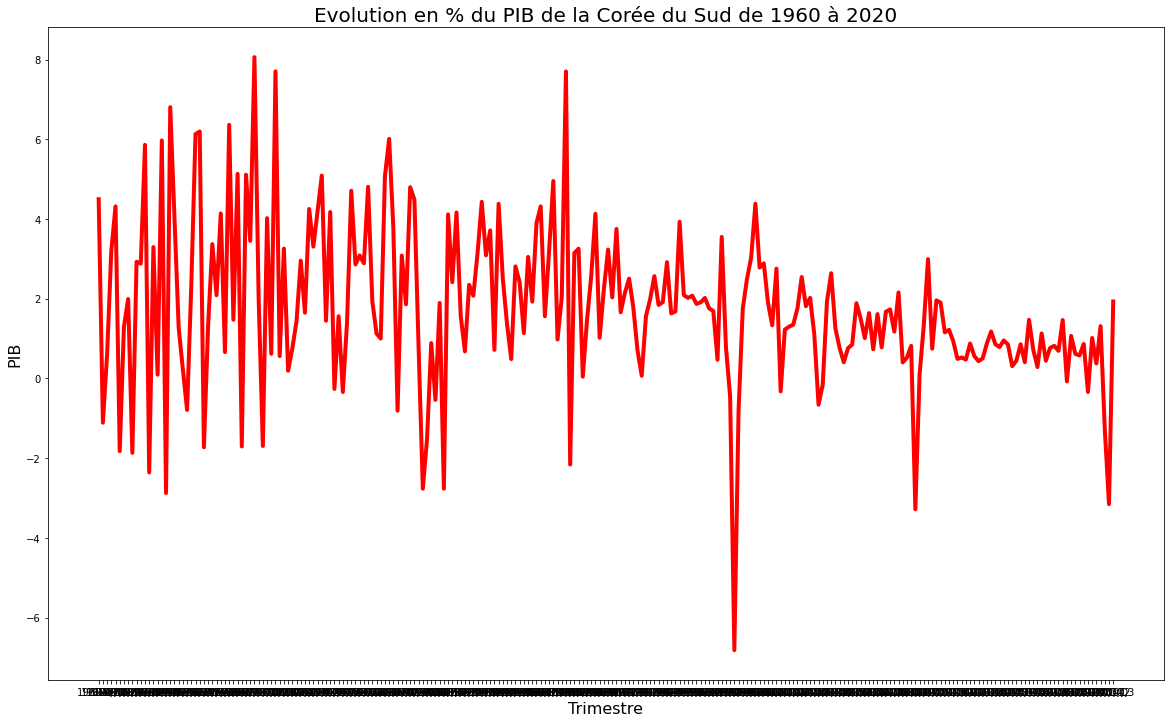

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))

plt.plot(kor['TIME'], kor['Value'], color='red', linewidth=4, markersize=10)


plt.xlabel('Trimestre', fontsize=16)
plt.ylabel('PIB', fontsize=16)


plt.title('Evolution en % du PIB de la Corée du Sud de 1960 à 2020', fontsize=20)
plt.show()

Le graphique ci-dessous représente la superposition de la moyenne mobile et de l'évolution du PIB.

Nous rappelons que le but d’un lissage par moyenne mobile est de faire apparaître l’allure de la tendance.

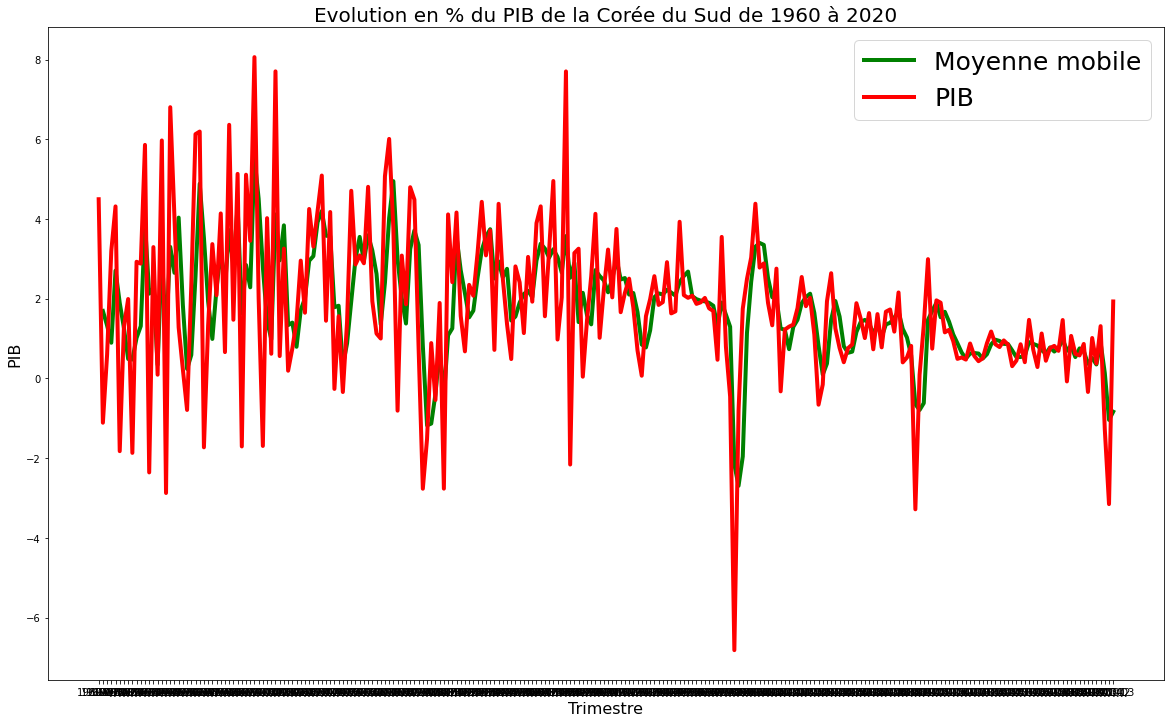

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))
plt.plot(kor['TIME'], kor['MM'], color='green',label='Moyenne mobile', linewidth=4, markersize=10)
plt.plot(kor['TIME'], kor['Value'], color='red',label='PIB', linewidth=4, markersize=10)


plt.xlabel('Trimestre', fontsize=16)
plt.ylabel('PIB', fontsize=16)
plt.legend(prop={"size":25})

plt.title('Evolution en % du PIB de la Corée du Sud de 1960 à 2020', fontsize=20)
plt.show()

# Modèle prédictif non linéaire

Nous avons réalisé un modèle de prédiction non linéaire de l'évolution de la variation du PIB pour cela nous avons utilisé le modèle ARIMA.

ARIMA pour AutoregRessive Integrated MovingAverage, est un modèle adapté aux séries temporelles, il permet de mieux comprendre et de prédire les valeurs futures de la série.

Pour effectuer ce modèle nous avons conservé dans un dataset seulement les moyennes mobiles et les dates.

In [15]:
korAC=kor[['TIME','MM']]
korAC=korAC.dropna()
korAC

,TIME,MM
1,1960-Q3,1.692221
2,1960-Q4,1.326914
3,1961-Q1,0.895221
4,1961-Q2,2.704550
5,1961-Q3,1.897368
...,...,...
237,2019-Q3,0.349968
238,2019-Q4,0.900409
239,2020-Q1,0.135128
240,2020-Q2,-1.041308


Le graphe ci-dessous correspond au graphique d'autocorrélation des valeurs des moyennes mobiles.

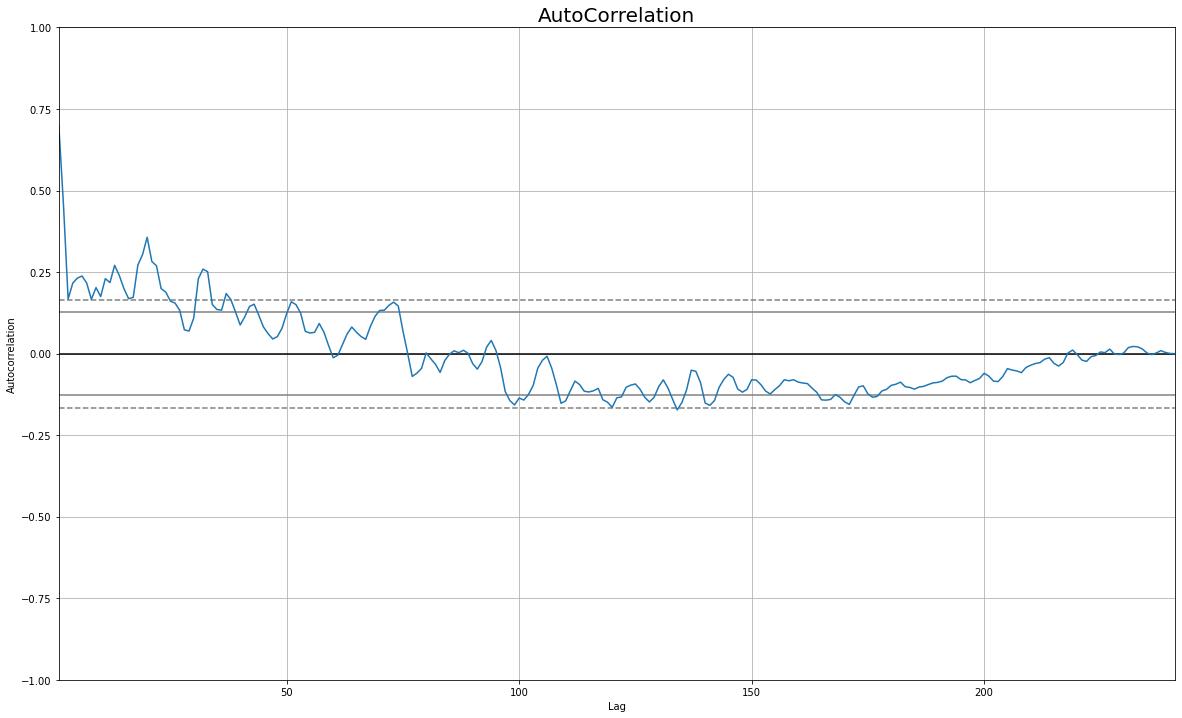

In [16]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(20,12))
autocorrelation_plot(korAC['MM'])
plt.title('AutoCorrelation',fontsize=20)
plt.show()

On transforme les données de la colonne 'TIME' du format YYYY-QQ à YYYY-MM-DD.

In [17]:
korAC['TIME']=[pd.to_datetime(x[:5]) + pd.offsets.QuarterBegin(int(x[6:])) for x in korAC['TIME']]
korAC

,TIME,MM
1,1960-09-01,1.692221
2,1960-12-01,1.326914
3,1961-03-01,0.895221
4,1961-06-01,2.704550
5,1961-09-01,1.897368
...,...,...
237,2019-09-01,0.349968
238,2019-12-01,0.900409
239,2020-03-01,0.135128
240,2020-06-01,-1.041308


In [18]:
korAC.dtypes

TIME    datetime64[ns]
MM             float64
dtype: object

On seléctionne les paramètres pour le modèle de série temporelle ARIMA.

Notre premier objectif est de trouver les valeurs ARIMA(p,d,q)(P,D,Q)s, ces paramètres vont nous permettre d'optimiser le modèle.

Les différents paramètres sont :
   - p: qui correspond à la partie auto régressive, ce paramètre permet d'incorporer les valeurs du passé dans notre modèle.
   - d: qui correspond au nombre de fois que les observations sont différenciées, c'est le degré de différenciation.
   - q: qui correspond à la taille de la fenêtre de la moyenne mobile de notre modèle. 

(p,d,q) sont des paramètres non saisonniers alors que (P,D,Q) suivent la même définition mais sont appliqués à la partie saisonnière de la série temporelle.

s correspond à la périodicité de la série, ici 4 puisque c'est en quartile.

In [19]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]


On modifie le dataset, en plaçant les données de la colonne 'TIME' en index.

In [20]:
korNL=korAC.copy()
korNL.set_index('TIME',inplace=True)
print(korNL)

                  MM
TIME                
1960-09-01  1.692221
1960-12-01  1.326914
1961-03-01  0.895221
1961-06-01  2.704550
1961-09-01  1.897368
...              ...
2019-09-01  0.349968
2019-12-01  0.900409
2020-03-01  0.135128
2020-06-01 -1.041308
2020-09-01 -0.834905

[241 rows x 1 columns]


Nous utilisons une «recherche de grille» pour explorer de manière itérative différentes combinaisons de paramètres. Pour chaque combinaison de paramètres, nous ajustons un nouveau modèle ARIMA saisonnier avec la fonction SARIMAX() et évaluons sa qualité globale en affichant le AIC.  

Commençons par générer les différentes combinaisons de paramètres que nous souhaitons évaluer:

In [21]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:

            mod = sm.tsa.statespace.SARIMAX(korNL,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, results.aic))


ARIMA(0, 0, 0)x(0, 0, 0, 4)4 - AIC:1054.0046461060315
ARIMA(0, 0, 0)x(0, 0, 1, 4)4 - AIC:940.4482431830909
ARIMA(0, 0, 0)x(0, 1, 0, 4)4 - AIC:883.4249903461132
ARIMA(0, 0, 0)x(0, 1, 1, 4)4 - AIC:739.6478532138168
ARIMA(0, 0, 0)x(1, 0, 0, 4)4 - AIC:854.3383041832967
ARIMA(0, 0, 0)x(1, 0, 1, 4)4 - AIC:746.7794583760941
ARIMA(0, 0, 0)x(1, 1, 0, 4)4 - AIC:816.45250238637
ARIMA(0, 0, 0)x(1, 1, 1, 4)4 - AIC:742.3622554722212
ARIMA(0, 0, 1)x(0, 0, 0, 4)4 - AIC:882.6729358136803
ARIMA(0, 0, 1)x(0, 0, 1, 4)4 - AIC:777.3298977096566
ARIMA(0, 0, 1)x(0, 1, 0, 4)4 - AIC:775.0637281175998
ARIMA(0, 0, 1)x(0, 1, 1, 4)4 - AIC:661.7909105960471
ARIMA(0, 0, 1)x(1, 0, 0, 4)4 - AIC:738.5074344011108
ARIMA(0, 0, 1)x(1, 0, 1, 4)4 - AIC:667.7158996924691
ARIMA(0, 0, 1)x(1, 1, 0, 4)4 - AIC:739.7202477512838
ARIMA(0, 0, 1)x(1, 1, 1, 4)4 - AIC:661.2370817956132
ARIMA(0, 1, 0)x(0, 0, 0, 4)4 - AIC:663.3855595590935
ARIMA(0, 1, 0)x(0, 0, 1, 4)4 - AIC:652.6322333815262
ARIMA(0, 1, 0)x(0, 1, 0, 4)4 - AIC:803.28575967

Le plus petit AIC correspond au meilleur modèle, ici c'est 614 ce qui correspond aux paramètres ARIMA(1, 1, 1)x(0, 1, 1, 4)4.

In [22]:
mod = sm.tsa.statespace.SARIMAX(korNL,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6115      0.053     11.644      0.000       0.509       0.714
ma.L1         -1.0203      0.053    -19.431      0.000      -1.123      -0.917
ma.S.L4       -0.9772      0.080    -12.223      0.000      -1.134      -0.821
sigma2         0.7374      0.095      7.750      0.000       0.551       0.924


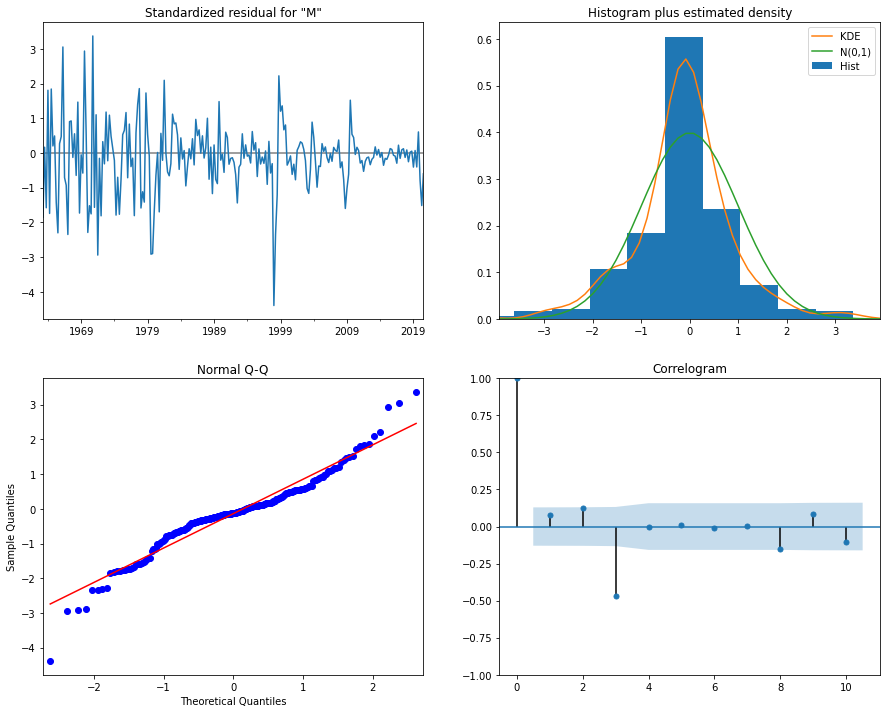

In [23]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Notre principale préoccupation est de nous assurer que les résidus de notre modèle ne sont pas corrélés et normalement distribués avec une moyenne nulle.

Dans ce cas, nos diagnostics de modèle suggèrent que les résidus du modèle sont normalement distribués en fonction des éléments suivants:

## Standardized residual & correlogram

Le graphique en haut à gauche n'affiche pas de saisonnalité évidente. Ceci est confirmé par le correlogram en bas à droite, il montre que la plupart des données ne sont pas corrélées, seuls certains points au début semblent être corrélés.  

## Histogramme

Dans le graphique en haut à droite, nous voyons que la ligne KDE orange suit a peu près la ligne N(0,1). 
Grâce à ce graphe on peut voir qu'en général les résidus sont normalement distribués sauf pour certains points.

## Graphique QQ normal

Ce graphique montre si les résidus sont normalement distribués. Un bon graphique QQ normal a tous les résidus se trouvant sur ou près de la ligne rouge, ce qui est à peu près le cas de notre graphique.

Certains points qui se situent loin de la ligne rouge. Ceci indique que les erreurs ne sont pas normalement distribuées, en fait notre modèle souffre de «queues lourdes».

Nous sommes donc plus susceptibles de voir des valeurs extrêmes que prévu si les données étaient réellement distribuées normalement.



On fait des prédiction à partir du Q3 de 1990.

In [24]:
pred = results.get_prediction(start=pd.to_datetime('1990-09-01'), dynamic=False)
pred_ci = pred.conf_int()

On trace le graphique en superposant la courbe des moyennes mobiles et la courbe de prédiction.

La partie en gris représente l'intervalle de confiance.

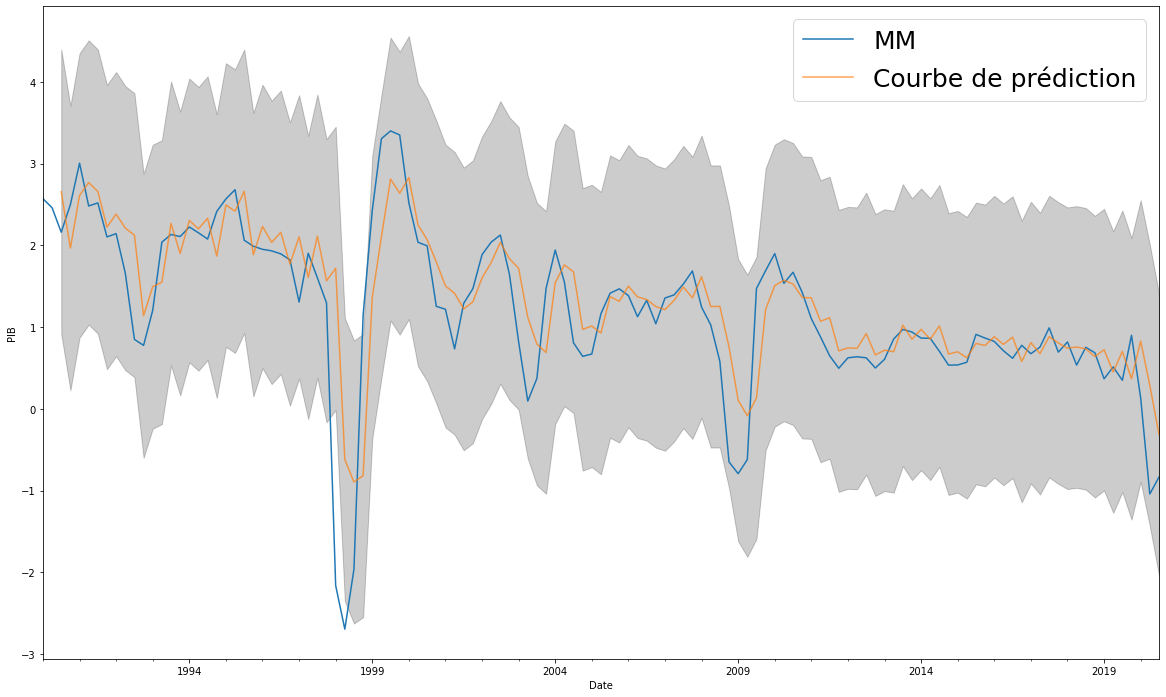

In [25]:

ax = korNL['1990':].plot(label='observed',figsize=(20,12))
pred.predicted_mean.plot(ax=ax, label='Courbe de prédiction', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('PIB')

plt.legend(prop={"size":25})

plt.show()

In [27]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=20)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

Le graphique ci-dessous représente la prédiction pour les 20 prochains quartiles après Q3 de 2020.

La partie en gris représente l'intervalle de confiance.

On peut voir que notre modèle prédit que le PIB va réaugmenter dans les prochains mois.

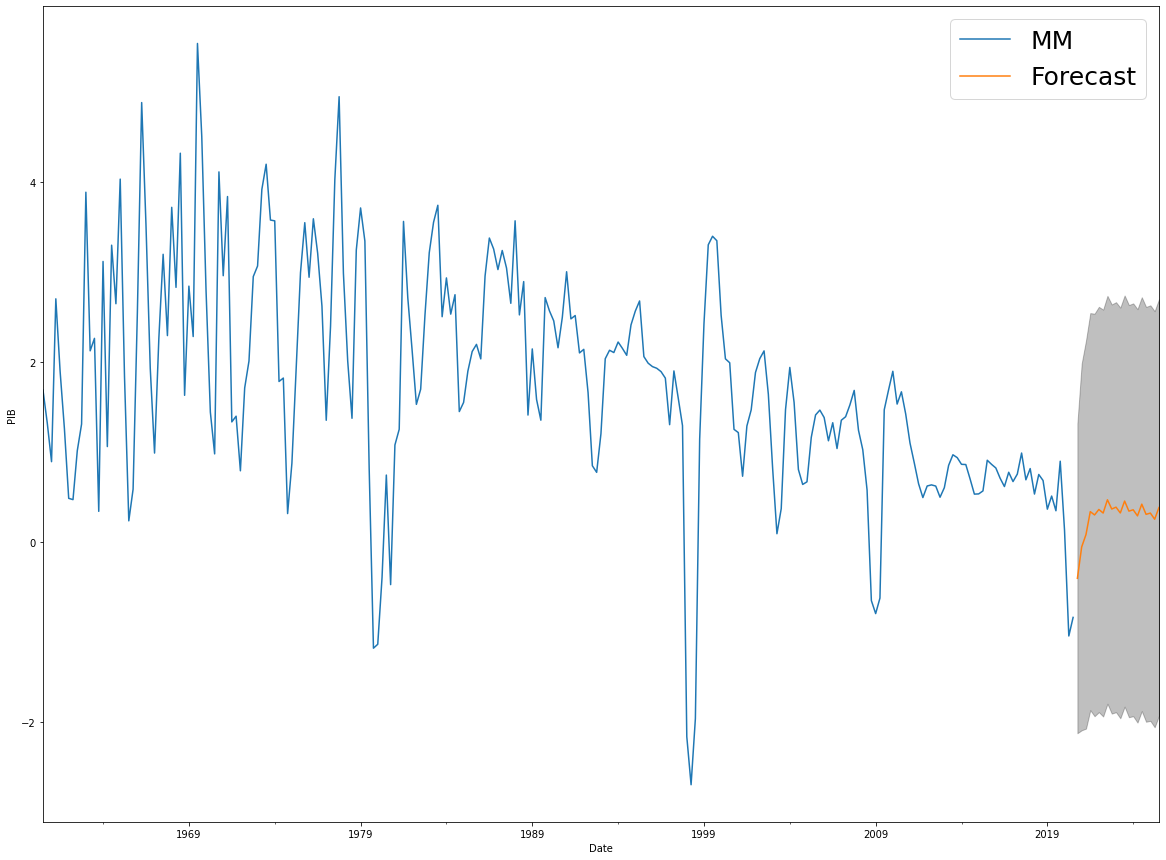

In [28]:
ax = korNL.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Prédiction')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('PIB')

plt.legend(prop={"size":25})
plt.show()

# Modèle de régression linéaire

Un modèle de régression linéaire est un modèle qui cherche  à établir une relation linéaire entre une ou plusieurs variables.

In [29]:
korAC

,TIME,MM
1,1960-09-01,1.692221
2,1960-12-01,1.326914
3,1961-03-01,0.895221
4,1961-06-01,2.704550
5,1961-09-01,1.897368
...,...,...
237,2019-09-01,0.349968
238,2019-12-01,0.900409
239,2020-03-01,0.135128
240,2020-06-01,-1.041308


On modifie le type de 'TIME' pour que les valeurs puissent être utilisées dans la régression linéaire.

In [30]:
import datetime as dt
korAC['TIME'] = pd.to_datetime(korAC['TIME'])
korAC['TIME']=korAC['TIME'].map(dt.datetime.toordinal)

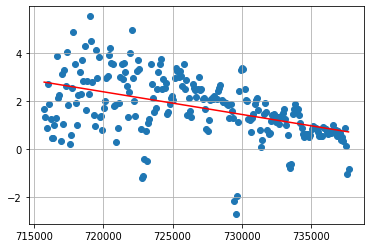

Prediction de 730 000 : 1.4487758886272104
Equation de la dorite :  -9.465099834882102e-05 *x +  70.54400468326655


In [42]:
from scipy import stats


def predict(x):
    return slope * x + intercept


X =  korAC.iloc[0:len(df),0] #selection de la première colonne de notre dataset
Y =  korAC.iloc[0:len(df),1]

axes = plt.axes()
axes.grid()
plt.scatter(X,Y)


slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)

fitLine = predict(X)
plt.plot(X, fitLine, c='r')
plt.show()

print('Prediction de 730 000 :',predict(730000))
print('Equation de la dorite : ',slope ,'*x + ',intercept)


Sur le graphique ci-dessus, on peut voir en rouge la droite qui établi la relation linéaire entre nos points.

En appelant la fonction predict, on peut prevoir lA variation de PIB à une période donnée. Par exemple, ici nous avons fait la prédiction de 730000 ce qui nous donne 1.44, cette valeur est cohérente avec notre droite. 

L'équation de la droite est de la forme : F(x)= slope*x + intercept. Ici nous avons donc comme équation environ -9.46*x+70.5. 

Point à améliorer : notre échelle dess abscisses de vrait être adaptée pour que les dates apparaissent.

# Conclusion

Nous avons fait deux modèles de prédiction, un linéaire avec la régression linéaire et l'autre non linéaire avec le modèle ARIMA. 

Selon nous, le modèle ARIMA est plus adapté pour faire des prédictions. En effet, on a pu voir que les prédictions faites sur les années passées sont assez cohérentes avec ce qu'il s'est réellement passé.